In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import networkx as nx
import seaborn as sns
from matplotlib.gridspec import GridSpec

from paths import PROJECT_ROOT
plots_dir = os.path.join(PROJECT_ROOT, "plots")

sns.set_theme(style="whitegrid", font_scale=1.4)

# Panel A

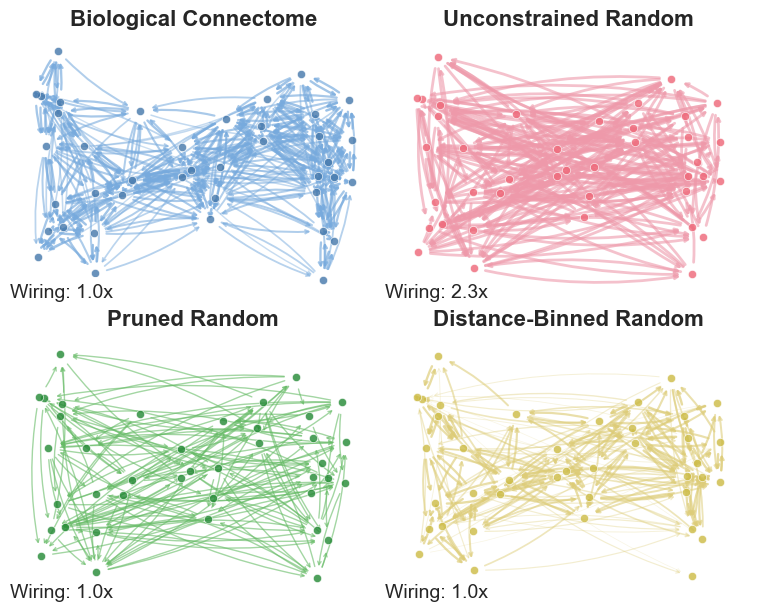

In [2]:
# Set up the figure with Nature-compatible settings
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5

# Create figure
fig1, axs = plt.subplots(2, 2, figsize=(7.5, 6), constrained_layout=True)
axs = axs.flatten()

# Set a seed for reproducibility
np.random.seed(42)

# Generate 3D coordinates for neurons - fixed to exactly n_nodes
n_nodes = 40
nodes_2d = np.zeros((n_nodes, 2))

# Create clusters of nodes
cluster_centers = [
    [0, 0],  # center
    [-1.5, 1],  # top left
    [1.5, 1],  # top right
    [-1.5, -1],  # bottom left
    [1.5, -1],  # bottom right
]

# Assign nodes to clusters with jitter
nodes_per_cluster = n_nodes // len(cluster_centers)
for i, center in enumerate(cluster_centers):
    start_idx = i * nodes_per_cluster
    end_idx = start_idx + nodes_per_cluster if i < len(cluster_centers) - 1 else n_nodes

    for j in range(start_idx, end_idx):
        # Add position with random jitter
        nodes_2d[j, 0] = center[0] + np.random.normal(0, 0.5)
        nodes_2d[j, 1] = center[1] + np.random.normal(0, 0.5)

# Create fake 3D positions (only needed for distance calculations)
nodes_3d = np.column_stack((nodes_2d, np.zeros(n_nodes)))

# Transform 3D to 2D coordinates for visualization
nodes_2d = nodes_3d[:, :2]

# Create a distance matrix
dist_matrix = np.zeros((n_nodes, n_nodes))
for i in range(n_nodes):
    for j in range(n_nodes):
        dist_matrix[i, j] = np.sqrt(np.sum((nodes_3d[i] - nodes_3d[j]) ** 2))

# Normalize distances
max_dist = np.max(dist_matrix)
norm_dist_matrix = dist_matrix / max_dist

# Define edge densities and colors with explicit wiring lengths
configs = [
    {
        "title": "Biological Connectome",
        "density": 0.1,
        "node_color": "#4477AA",
        "edge_color": "#77AADD",
        "rel_length": 1.0,
        "prefers_short": True,
    },
    {
        "title": "Unconstrained Random",
        "density": 0.15,
        "node_color": "#EE6677",
        "edge_color": "#EE99AA",
        "rel_length": 2.3,
        "prefers_short": False,
    },
    {
        "title": "Pruned Random",
        "density": 0.1,
        "node_color": "#228833",
        "edge_color": "#66BB66",
        "rel_length": 1.0,
        "prefers_short": False,
    },
    {
        "title": "Distance-Binned Random",
        "density": 0.1,
        "node_color": "#CCBB44",
        "edge_color": "#DDCC77",
        "rel_length": 1.0,
        "prefers_short": True,
    },
]

# Generate the graphs for each configuration
for idx, config in enumerate(configs):
    # Create a new graph
    G = nx.DiGraph()

    # Add nodes
    for i in range(n_nodes):
        G.add_node(i, pos=nodes_2d[i])

    # Create edges based on configuration
    edges_to_add = []

    if config["title"] == "Biological Connectome":
        # Much stronger preference for short connections
        distance_threshold = 0.6  # Only allow connections below this normalized distance
        
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and norm_dist_matrix[i, j] < distance_threshold:
                    # Higher probability for shorter connections
                    p_connect = (1 - norm_dist_matrix[i, j]/distance_threshold)**2 * config["density"] * 15
                    if np.random.random() < p_connect:
                        weight = 1.0  # Consistent weight
                        edges_to_add.append((i, j, {'weight': weight, 'distance': dist_matrix[i, j]}))
    
    elif config["title"] == "Unconstrained Random":
        # Random connections regardless of distance
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and np.random.random() < config["density"]:
                    weight = np.random.uniform(0.5, 1)
                    edges_to_add.append(
                        (i, j, {"weight": weight, "distance": dist_matrix[i, j]})
                    )

    elif config["title"] == "Pruned Random":
        # Random connections regardless of distance
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and np.random.random() < config["density"]:
                    weight = np.random.uniform(0.2, 0.7)
                    edges_to_add.append(
                        (i, j, {"weight": weight, "distance": dist_matrix[i, j]})
                    )

    elif config["title"] == "Distance-Binned Random":
        # Divide distances into bins and randomize within each bin
        dist_bins = [
            0,
            0.3,
            0.6,
            1.0,
        ]  # Three distance bins with emphasis on shorter connections
        bin_densities = [0.3, 0.1, 0.05]  # Higher density for shorter connections

        for bin_idx in range(len(dist_bins) - 1):
            bin_min, bin_max = dist_bins[bin_idx], dist_bins[bin_idx + 1]
            bin_density = bin_densities[bin_idx]

            # Find node pairs in this distance bin
            bin_pairs = []
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i != j and bin_min <= norm_dist_matrix[i, j] < bin_max:
                        bin_pairs.append((i, j))

            # Randomly select pairs from this bin
            np.random.shuffle(bin_pairs)
            bin_edges_count = int(len(bin_pairs) * bin_density)

            for i, j in bin_pairs[:bin_edges_count]:
                weight = np.random.uniform(0.5, 1.0)
                edges_to_add.append(
                    (i, j, {"weight": weight, "distance": dist_matrix[i, j]})
                )

    # Add the edges to the graph
    for u, v, data in edges_to_add:
        G.add_edge(u, v, **data)

    # Get positions and draw
    pos = nx.get_node_attributes(G, "pos")

    # Calculate node sizes based on degree
    node_sizes = [20 + 3 * G.degree(n) for n in G.nodes()]

    
    
    # Draw the nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        ax=axs[idx],
        node_size=35,
        node_color=config["node_color"],
        alpha=0.8,
        edgecolors="white",
        linewidths=0.5,
    )

    # Draw edges with color and width encoding distance
    # Short connections: thicker and more opaque
    # Long connections: thinner and more transparent
    for u, v, data in G.edges(data=True):
        distance = data["distance"] / max_dist

        # Determine edge properties based on distance
        if config["prefers_short"]:
            # For configurations that prefer short connections
            width = max(0.5, 2.0 * (1.0 - distance))
            alpha = max(0.2, 0.8 * (1.0 - distance))
        else:
            # For configurations that don't differentiate by distance
            width = 1.0
            alpha = 0.6

        nx.draw_networkx_edges(
            G,
            pos,
            ax=axs[idx],
            edgelist=[(u, v)],
            width=width * 2 if config["title"] == "Unconstrained Random" else width,
            alpha=alpha,
            edge_color=config["edge_color"],
            arrows=True,
            arrowsize=6,
            arrowstyle="->",
            connectionstyle="arc3,rad=0.1",
        )

    # Add title and wiring info
    axs[idx].set_title(config["title"], fontsize=16, fontweight="bold")
    axs[idx].text(
        0.,
        0.,
        f"Wiring: {config['rel_length']:.1f}x",
        transform=axs[idx].transAxes,
        fontsize=14,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    )

    # Remove axes
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].spines["top"].set_visible(False)
    axs[idx].spines["right"].set_visible(False)
    axs[idx].spines["bottom"].set_visible(False)
    axs[idx].spines["left"].set_visible(False)

# plt.suptitle("Network Configuration Comparison", fontsize=10, fontweight="bold")
plt.savefig(os.path.join(plots_dir, "figure2a_network_configs.png"), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(plots_dir, "figure2a_network_configs.pdf"), bbox_inches="tight")
plt.show()

# Panel b

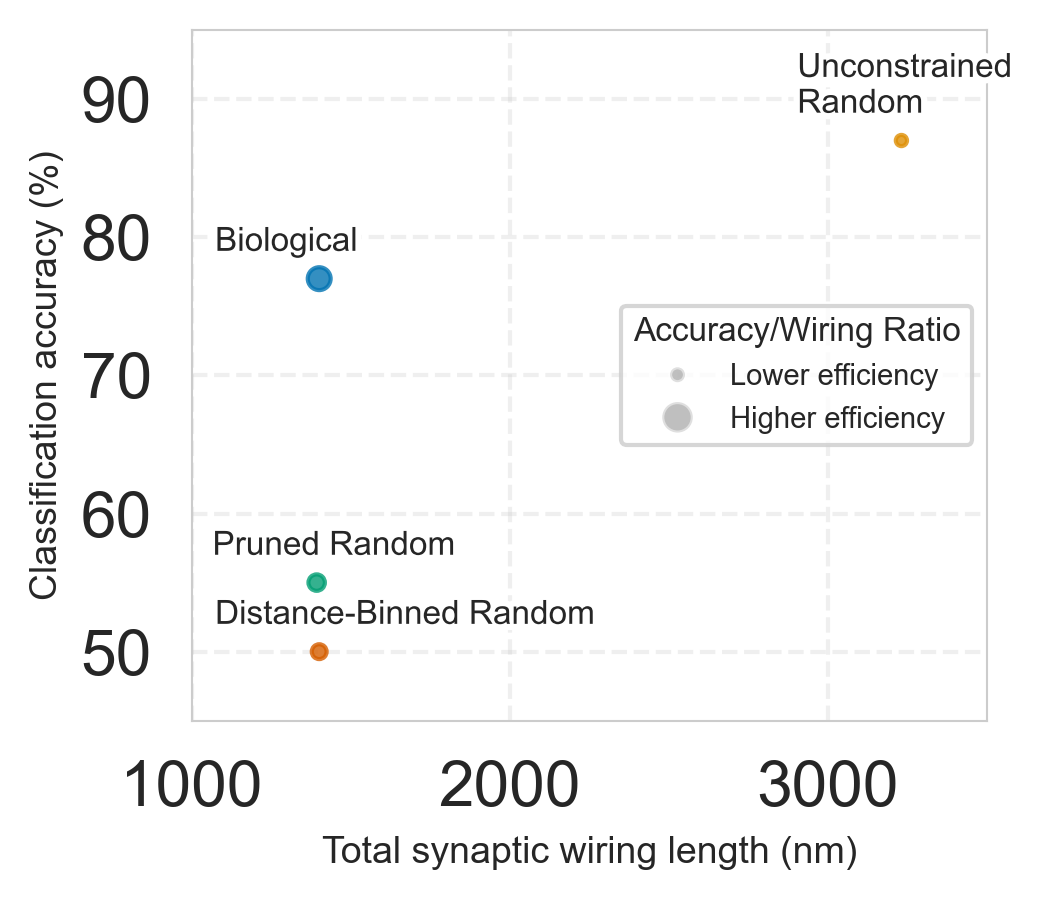

In [3]:
# Data from Table 4.2 in your manuscript
networks = [
    "Biological",
    "Unconstrained\nRandom",
    "Pruned Random",
    "Distance-Binned Random",
]
wiring_length = [1401, 3231, 1393, 1401]  # Total synaptic length (mm)
accuracy = [77, 87, 55, 50]  # Mean accuracy (%)
neurons_activated = [57, 75, 75, 57]  # Percentage of neurons activated

# Calculate efficiency (accuracy per unit wiring)
efficiency = [acc / length * 100 for acc, length in zip(accuracy, wiring_length)]

# Colors that work well for Nature (colorblind-friendly, print-friendly)
colors = ["#0173B2", "#DE8F05", "#029E73", "#D55E00"]

# Create the figure with Nature-compatible dimensions
fig2, ax = plt.subplots(figsize=(3.5, 3.2), dpi=300)  # Nature's single column width

# Create scatter plot with varying point sizes based on efficiency
sizes = [e ** 2 for e in efficiency]  # Scale efficiency for better visualization
scatter = ax.scatter(wiring_length, accuracy, s=sizes, c=colors, alpha=0.8, zorder=3)

"""# Connect points with a line to show the trade-off
# Only connect biological to unconstrained random to show the main comparison
ax.plot(
    [wiring_length[0], wiring_length[1]],
    [accuracy[0], accuracy[1]],
    "k--",
    alpha=0.3,
    zorder=1,
)"""

# Add labels with a white outline for better visibility
for i, txt in enumerate(networks):
    text = ax.annotate(
        txt,
        (wiring_length[i], accuracy[i]),
        fontsize=8,
        ha="left",
        va="bottom",
        xytext=(-25, 5),
        textcoords="offset points",
    )
    text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="white")])

# Add x and y-axis labels with units
ax.set_xlabel("Total synaptic wiring length (nm)", fontsize=9)
ax.set_ylabel("Classification accuracy (%)", fontsize=9)

# Set axis limits with some padding
ax.set_xlim(1000, 3500)
ax.set_ylim(45, 95)

# Add grid for readability (light grid typical for Nature figures)
ax.grid(linestyle="--", alpha=0.3, zorder=0)


# Create legend for the point sizes representing efficiency
# Create custom handles for legend
class SizedPatchHandler(HandlerPatch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        size = orig_handle.get_width()
        p = mpatches.Circle(
            (0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            size / 3,
            edgecolor=orig_handle.get_edgecolor(),
            facecolor=orig_handle.get_facecolor(),
            transform=trans,
        )
        return [p]


# Create legend handles
efficiency_levels = [min(efficiency), max(efficiency)]
legend_sizes = [e * 2 for e in efficiency_levels]
legend_labels = [f"{e:.1f}" for e in efficiency_levels]

handles = [
    mpatches.Rectangle(
        (0, 0), legend_sizes[0], legend_sizes[0], facecolor="gray", alpha=0.5
    ),
    mpatches.Rectangle(
        (0, 0), legend_sizes[1], legend_sizes[1], facecolor="gray", alpha=0.5
    ),
]

# Add legend with custom handler
ax.legend(
    handles,
    [f"Lower efficiency", f"Higher efficiency"],
    title="Accuracy/Wiring Ratio",
    handler_map={mpatches.Rectangle: SizedPatchHandler()},
    loc="center right",
    fontsize=7,
    title_fontsize=8,
)

# Adjust layout and save
plt.tight_layout()
fig2.subplots_adjust(right=0.98, top=0.95)

# Save figure with transparent background (Nature preference)
plt.savefig(os.path.join(plots_dir,"figure2_panel_b.png"), dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(os.path.join(plots_dir,"figure2_panel_b.pdf"), bbox_inches="tight") 
plt.show()

# Pancel c

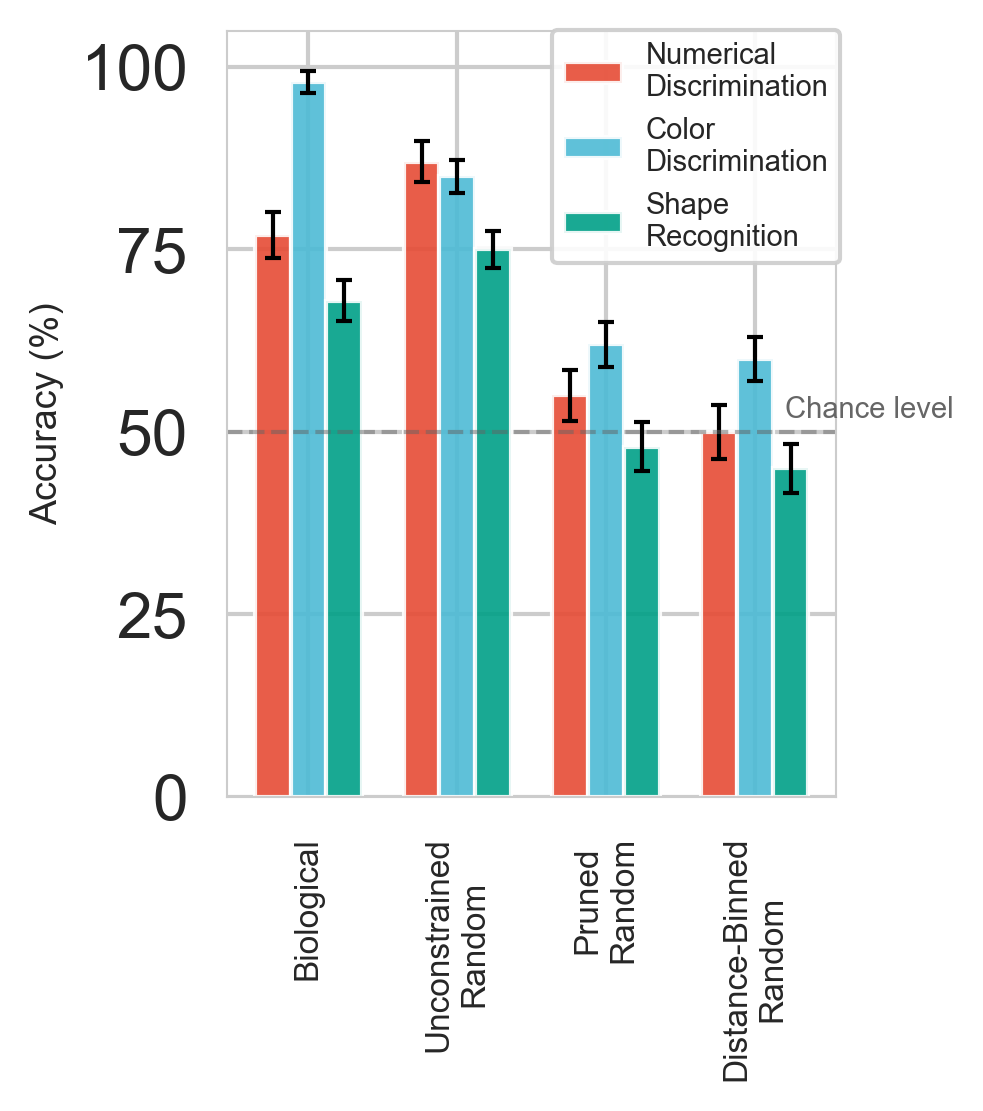

In [4]:
# Network configurations
networks = [
    "Biological",
    "Unconstrained\nRandom",
    "Pruned\nRandom",
    "Distance-Binned\nRandom",
]

# Made-up performance data for three tasks (percentage accuracy)
numerical_task = [77, 87, 55, 50]  # From your Table 4.2
color_task = [98, 85, 62, 60]  # Made up - biological better for color
shape_task = [68, 75, 48, 45]  # Made up - unconstrained better for shapes

# Made-up error bars (standard error)
numerical_err = [3.2, 2.8, 3.5, 3.7]
color_err = [1.5, 2.2, 3.1, 3.0]
shape_err = [2.8, 2.5, 3.3, 3.4]

# Nature color palette (starts with red and blue)
colors = ["#E64B35", "#4DBBD5", "#00A087"]

# Set width of bars
bar_width = 0.24
capsize = 2
index = np.arange(len(networks))

# Create the figure with Nature-compatible dimensions
fig3, ax = plt.subplots(
    figsize=(3.5, 3.5), dpi=300
)  # Slightly taller to accommodate vertical labels

# Create grouped bars in the requested order with error bars
bars1 = ax.bar(
    index - bar_width,
    numerical_task,
    bar_width,
    yerr=numerical_err,
    label="Numerical\nDiscrimination",
    color=colors[0],
    alpha=0.9,
    capsize=capsize,
    ecolor="black",
    error_kw={"elinewidth": 1},
)
bars2 = ax.bar(
    index,
    color_task,
    bar_width,
    yerr=color_err,
    label="Color\nDiscrimination",
    color=colors[1],
    alpha=0.9,
    capsize=capsize,
    ecolor="black",
    error_kw={"elinewidth": 1},
)
bars3 = ax.bar(
    index + bar_width,
    shape_task,
    bar_width,
    yerr=shape_err,
    label="Shape\nRecognition",
    color=colors[2],
    alpha=0.9,
    capsize=capsize,
    ecolor="black",
    error_kw={"elinewidth": 1},
)

# Add horizontal line for chance level (50% for binary classification)
ax.axhline(y=50, linestyle="--", color="#666666", alpha=0.5, linewidth=1)

# Add text label for chance level
ax.text(len(networks) - 0.8, 52, "Chance level", fontsize=7, color="#666666")

# Add labels and custom x-axis tick labels
ax.set_ylabel("Accuracy (%)", fontsize=9)
ax.set_ylim(0, 105)  # Slightly higher to accommodate error bars
ax.set_xticks(index)
ax.set_xticklabels(networks, fontsize=8, rotation=90)  # Vertical labels

# Add a legend
ax.legend(bbox_to_anchor=(1.03, 1.02), fontsize=7, loc="upper right", framealpha=0.9)

# No grid lines as requested
"""
# Add panel label (c) in the Nature style
ax.text(
    -0.15, 1.05, "c", transform=ax.transAxes, fontsize=12, fontweight="bold", va="top"
)
"""
# Adjust layout with extra bottom margin for vertical labels
plt.tight_layout()
fig3.subplots_adjust(bottom=0.2)  # Make room for vertical labels

# Save figure with transparent background (Nature preference)
plt.savefig(os.path.join(plots_dir, "figure2_panel_c.png"), dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(os.path.join(plots_dir, "figure2_panel_c.pdf"), bbox_inches="tight") 
plt.show()

# Panel d

Changed working directory to /home/eudald/Desktop/doctorat/connectome
Project root: /home/eudald/Desktop/doctorat/connectome


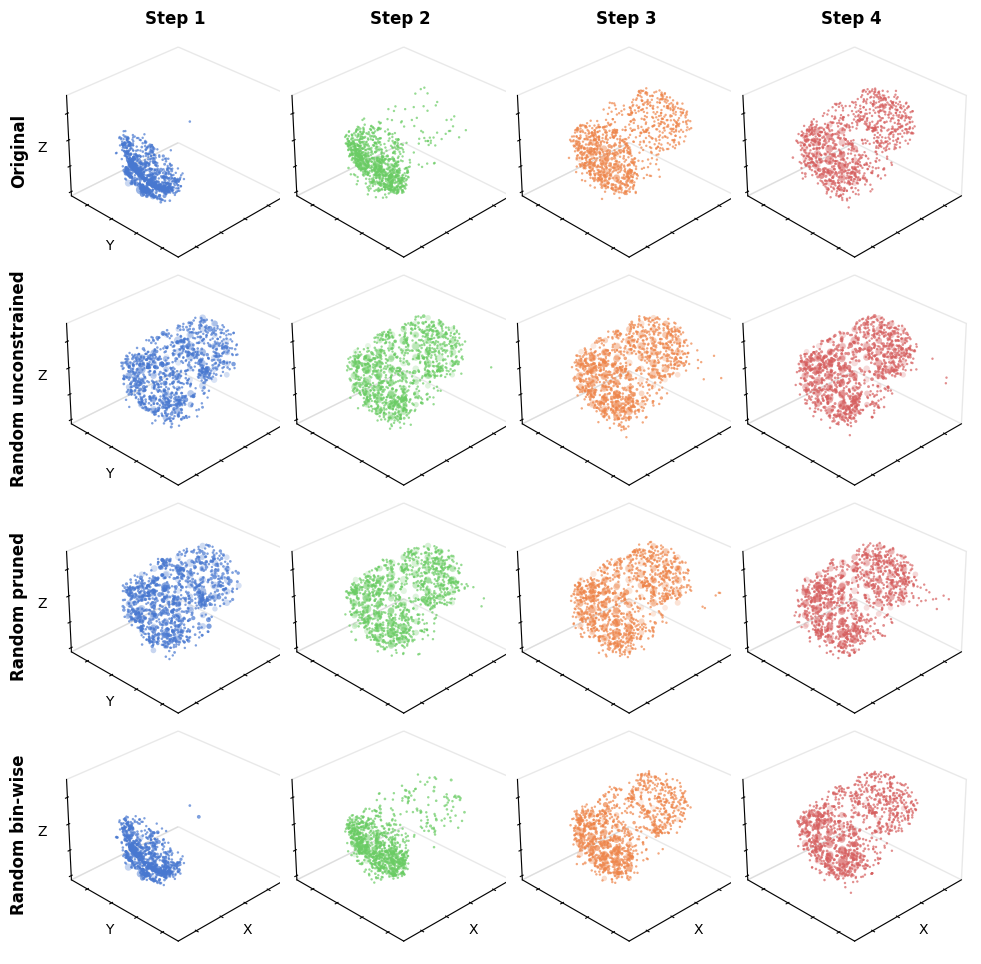

In [3]:
import os
from notebooks.visualization.activation_plots import visualize_steps_separated_compact
from notebooks.visualization.activations_funcs import get_activation_dictionnary, load_neuron_position_data
import matplotlib.pyplot as plt

configurations = get_activation_dictionnary()
neuron_position_data = load_neuron_position_data()

fig4 = visualize_steps_separated_compact(
    configurations,
    neuron_position_data,
    max_neurons_per_step=1000,
    voxel_size=10,
    smoothing=0.5,
    padding_percent=5,
)

# Save figure with transparent background (Nature preference)
#plt.savefig(os.path.join(plots_dir, "figure2_panel_d.png"), dpi=300, bbox_inches="tight", transparent=True)
#plt.savefig(os.path.join(plots_dir, "figure2_panel_d.pdf"), bbox_inches="tight") 
plt.show()

# All together

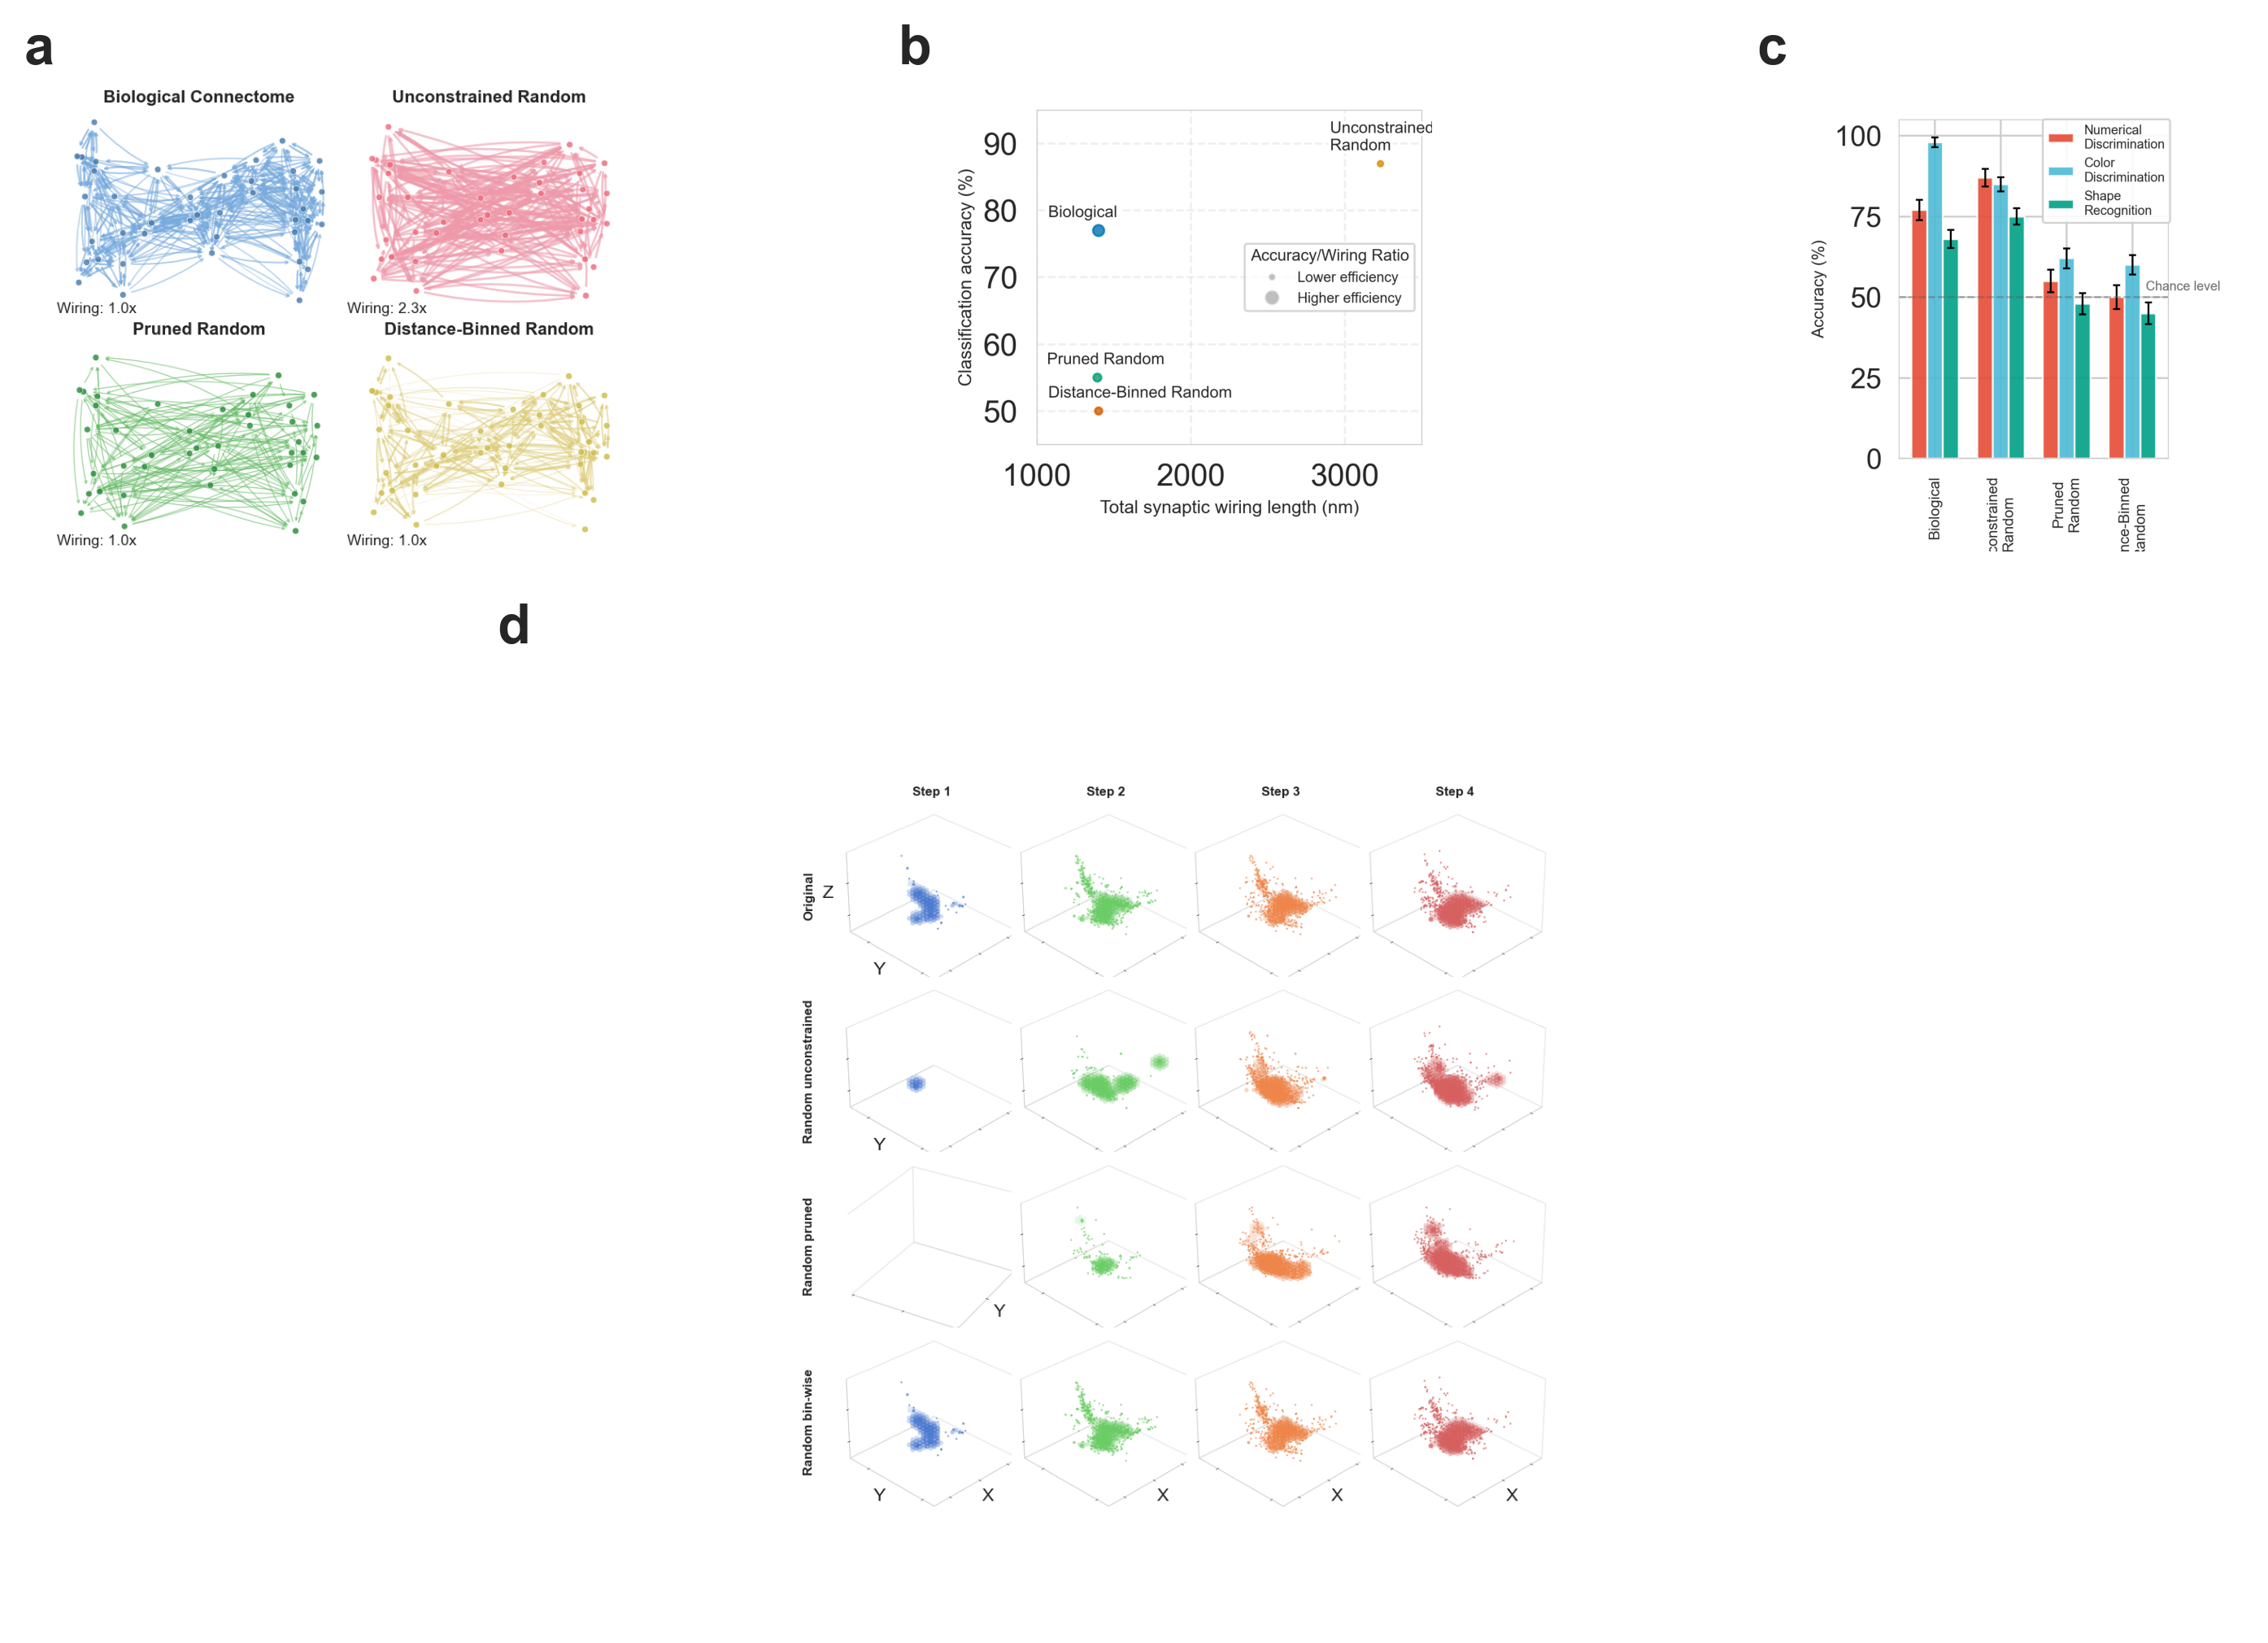

In [6]:
# Create a new composite figure
fig = plt.figure(
    figsize=(10.5, 7.0), dpi=300
)  # Wider figure to accommodate 3 plots in top row

# Create a custom grid - 2 rows, 3 columns
# First row will have 3 equal plots (a, b, c)
# Second row will have 1 plot (d) spanning all 3 columns
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 2])  # Make bottom row twice as tall


# Function to transfer content from one figure to a subplot in another figure
def transfer_figure_to_axes(source_fig, target_axes):
    # Get the renderer from the source figure
    canvas = source_fig.canvas
    if canvas is None:
        canvas = FigureCanvas(source_fig)

    # Convert the source figure to an image
    source_fig.canvas.draw()
    image = np.array(source_fig.canvas.renderer.buffer_rgba())

    # Display the image in the target axes
    target_axes.imshow(image)
    target_axes.axis("off")


# Create subplots for a, b, c in top row
ax1 = fig.add_subplot(gs[0, 0])  # Plot a - top left
ax2 = fig.add_subplot(gs[0, 1])  # Plot b - top middle
ax3 = fig.add_subplot(gs[0, 2])  # Plot c - top right

# Create subplot for d spanning the entire bottom row
ax4 = fig.add_subplot(gs[1, :])  # Plot d - entire bottom row

# Transfer each figure to its respective subplot
transfer_figure_to_axes(fig1, ax1)
transfer_figure_to_axes(fig2, ax2)
transfer_figure_to_axes(fig3, ax3)
transfer_figure_to_axes(fig4, ax4)

# Add panel labels
x_off = -0.05
y_off = 1.05
ax1.text(x_off, y_off, "a", transform=ax1.transAxes, fontsize=16, fontweight="bold")
ax2.text(x_off, y_off, "b", transform=ax2.transAxes, fontsize=16, fontweight="bold")
ax3.text(x_off, y_off, "c", transform=ax3.transAxes, fontsize=16, fontweight="bold")
ax4.text(x_off, y_off, "d", transform=ax4.transAxes, fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig(
    os.path.join(plots_dir, "network_configs_panel.png"), dpi=300, bbox_inches="tight"
)
plt.savefig(os.path.join(plots_dir, "network_configs_panel.pdf"), bbox_inches="tight")
plt.show()

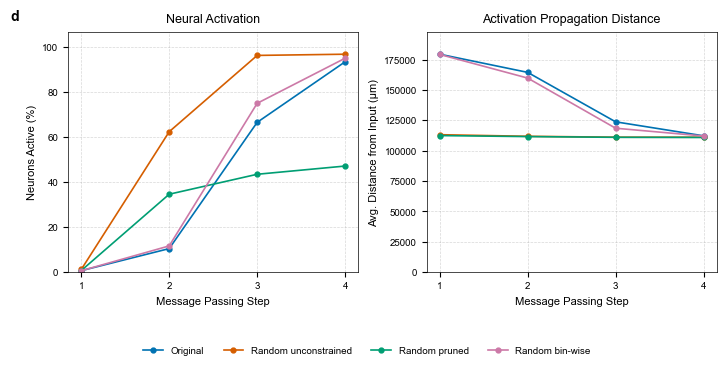

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl


def plot_activation_statistics_nature(
    propagations_dict, neuron_position_data, fig_width=183, dpi=600, panel_label="d"
):
    """
    Plot statistics about neuronal activations across different configurations in Nature journal style.

    Parameters:
    -----------
    propagations_dict : dict
        Dictionary of DataFrames with activation data for different configurations
    neuron_position_data : DataFrame
        DataFrame containing position data for neurons
    fig_width : int
        Width in mm (183mm for double-column in Nature)
    dpi : int
        Resolution (Nature requires at least 300 dpi)
    panel_label : str
        Label for this panel in a multi-panel figure

    Returns:
    --------
    matplotlib.figure.Figure
        A Nature-style figure with activation statistics
    """
    # Set Nature style parameters
    mpl.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial", "Helvetica"],
            "font.size": 7,
            "axes.labelsize": 8,
            "axes.titlesize": 9,
            "xtick.labelsize": 7,
            "ytick.labelsize": 7,
            "legend.fontsize": 7,
            "axes.linewidth": 0.5,
            "grid.linewidth": 0.5,
            "lines.linewidth": 1.0,
            "lines.markersize": 3,
        }
    )

    # Nature-friendly color scheme
    colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9", "#E69F00"]

    # Calculate metrics for each configuration
    configs = list(propagations_dict.keys())
    activation_percentages = {config: [] for config in configs}
    activation_distances = {config: [] for config in configs}

    # Get bounds of neuron positions
    x_min, x_max = (
        neuron_position_data["pos_x"].min(),
        neuron_position_data["pos_x"].max(),
    )
    y_min, y_max = (
        neuron_position_data["pos_y"].min(),
        neuron_position_data["pos_y"].max(),
    )
    z_min, z_max = (
        neuron_position_data["pos_z"].min(),
        neuron_position_data["pos_z"].max(),
    )

    for config, prop_df in propagations_dict.items():
        # Calculate percentage of neurons active at each step
        total_neurons = len(neuron_position_data)

        for step in range(1, 5):
            act_col = f"activation_{step}"
            if act_col in prop_df.columns:
                active_neurons = prop_df[prop_df[act_col] > 0]["root_id"].nunique()
                activation_percentages[config].append(
                    100 * active_neurons / total_neurons
                )
            else:
                activation_percentages[config].append(0)

        # Calculate average distance of active neurons from eye
        eye_position = np.array(
            [x_min, (y_max + y_min) / 2, (z_max + z_min) / 2]
        )  # Approximate

        merged = pd.merge(prop_df, neuron_position_data, on="root_id")
        for step in range(1, 5):
            act_col = f"activation_{step}"
            if act_col in merged.columns:
                active = merged[merged[act_col] > 0]
                if len(active) > 0:
                    positions = active[["pos_x", "pos_y", "pos_z"]].values
                    distances = np.sqrt(np.sum((positions - eye_position) ** 2, axis=1))
                    activation_distances[config].append(np.mean(distances))
                else:
                    activation_distances[config].append(0)
            else:
                activation_distances[config].append(0)

    # Convert mm to inches (1 mm = 0.0393701 inches)
    fig_width_in = fig_width * 0.0393701
    fig_height_in = fig_width_in / 2.1  # For a 2-panel horizontal layout

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width_in, fig_height_in))

    # Plot 1: Percentage of active neurons by step
    for i, config in enumerate(configs):
        ax1.plot(
            range(1, 5),
            activation_percentages[config],
            marker="o",
            label=config,
            color=colors[i % len(colors)],
            linewidth=1.2,
            markersize=3.5,
        )

    ax1.set_xlabel("Message Passing Step")
    ax1.set_ylabel("Neurons Active (%)")
    ax1.set_title("Neural Activation", pad=7)
    ax1.grid(True, linestyle="--", alpha=0.5, linewidth=0.5)

    # Ensure integer x-axis ticks
    ax1.set_xticks(range(1, 5))

    # Set y-axis range starting from 0
    ymax1 = max([max(vals) for vals in activation_percentages.values()]) * 1.1
    ax1.set_ylim(0, ymax1)

    # Plot 2: Average distance of activated neurons
    for i, config in enumerate(configs):
        ax2.plot(
            range(1, 5),
            activation_distances[config],
            marker="o",
            label=config,
            color=colors[i % len(colors)],
            linewidth=1.2,
            markersize=3.5,
        )

    ax2.set_xlabel("Message Passing Step")
    ax2.set_ylabel("Avg. Distance from Input (μm)")
    ax2.set_title("Activation Propagation Distance", pad=7)
    ax2.grid(True, linestyle="--", alpha=0.5, linewidth=0.5)

    # Ensure integer x-axis ticks
    ax2.set_xticks(range(1, 5))

    # Set y-axis range
    ymax2 = max([max(vals) for vals in activation_distances.values()]) * 1.1
    ax2.set_ylim(0, ymax2)

    # Add single legend for both plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.01),
        ncol=len(configs),
        frameon=False,
    )

    # Add panel label
    ax1.text(
        -0.2,
        1.05,
        panel_label,
        transform=ax1.transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for legend at bottom

    return fig


# Example usage:
# fig = plot_activation_statistics_nature(propagations_dict, neuron_position_data, panel_label='d')
# plt.savefig("Figure3d_activation_stats.tif", dpi=600, bbox_inches='tight')
# plt.savefig("Figure3d_activation_stats.pdf", dpi=600, bbox_inches='tight')
# plt.close()


fig = plot_activation_statistics_nature(configurations, neuron_position_data)
plt.show()

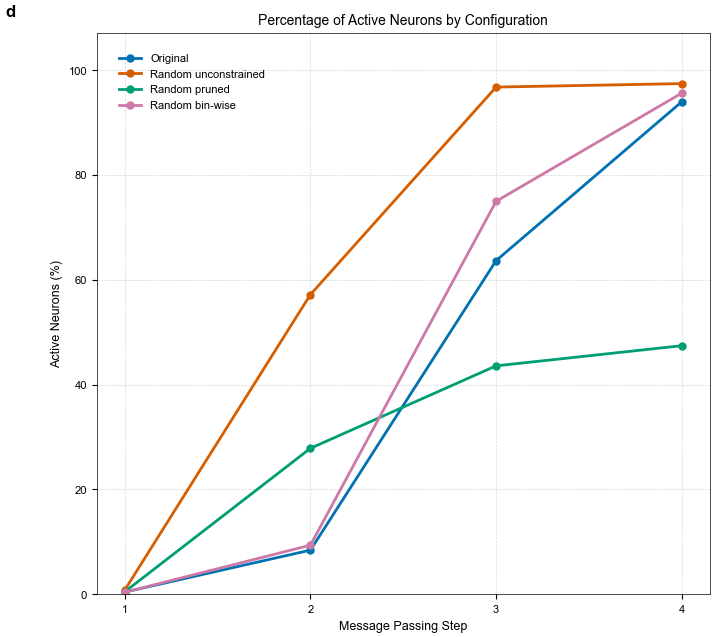

In [5]:
import matplotlib.pyplot as plt
import pandas as pd


def create_active_neurons_plot(
    propagation_dict, colors=None, fig_width=89, dpi=600, activation_threshold=0
):
    """
    Create a Nature-style plot showing percentage of active neurons
    across different connectome configurations.

    Parameters:
    -----------
    propagation_dict : dict
        Dictionary of DataFrames for different connectome configurations
    colors : list of str, optional
        Colors for each configuration
    fig_width : int
        Width in mm (Nature single column is 89mm, double column is 183mm)
    dpi : int
        Resolution (Nature requires at least 300 dpi)
    activation_threshold : float
        Threshold for considering a neuron active

    Returns:
    --------
    matplotlib.figure.Figure
        A Nature-style figure with active neurons plot
    """
    # Set Nature style
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial", "Helvetica"],
            "font.size": 8,
            "axes.labelsize": 9,
            "axes.titlesize": 10,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            "legend.fontsize": 8,
            "figure.titlesize": 10,
            "axes.linewidth": 0.5,
            "grid.linewidth": 0.5,
            "lines.linewidth": 1.5,
            "lines.markersize": 4,
            "savefig.dpi": dpi,
            "savefig.format": "tiff",
            "savefig.bbox": "tight",
            "savefig.pad_inches": 0.05,
        }
    )

    # Default Nature-friendly colors if not provided
    if colors is None:
        colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7"]

    # Convert mm to inches (1 mm = 0.0393701 inches)
    fig_width_in = fig_width * 0.0393701

    # Figure height
    fig_height_in = fig_width_in * 0.9  # Slightly less than square for single plot

    # Create figure
    fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))

    # Calculate activation metrics for each configuration
    all_metrics = []

    for label, prop_df in propagation_dict.items():
        metrics = []

        # Calculate metrics for each activation step
        for step in range(1, 5):
            activation_col = f"activation_{step}"

            # Skip if column doesn't exist
            if activation_col not in prop_df.columns:
                continue

            # Count active neurons
            active_neurons = prop_df[prop_df[activation_col] > activation_threshold]
            active_count = len(active_neurons)
            total_count = len(prop_df)

            # Calculate percentage of active neurons
            percent_active = (
                (active_count / total_count) * 100 if total_count > 0 else 0
            )

            # Store metrics
            metrics.append(
                {
                    "Step": step,
                    "Active Neurons (%)": percent_active,
                }
            )

        # Add to overall metrics with configuration label
        metrics_df = pd.DataFrame(metrics)
        metrics_df["Configuration"] = label
        all_metrics.append(metrics_df)

    # Combine all metrics
    combined_metrics = pd.concat(all_metrics)

    # Plot each configuration
    for j, config in enumerate(propagation_dict.keys()):
        config_data = combined_metrics[combined_metrics["Configuration"] == config]

        # Plot line
        ax.plot(
            config_data["Step"],
            config_data["Active Neurons (%)"],
            marker="o",
            label=config,
            color=colors[j % len(colors)],
            linewidth=2,
            markersize=5,
        )

    # Set labels and title
    ax.set_xlabel("Message Passing Step")
    ax.set_ylabel("Active Neurons (%)")
    ax.set_title("Percentage of Active Neurons by Configuration")

    # Set x-axis ticks to integers
    ax.set_xticks(range(1, 5))

    # Set y-axis range from 0 to appropriate max with some padding
    y_max = combined_metrics["Active Neurons (%)"].max() * 1.1
    ax.set_ylim(0, y_max)

    # Add grid
    ax.grid(True, linestyle="--", alpha=0.5, linewidth=0.5)

    # Add legend with improved positioning
    ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.02, 0.98), ncol=1)

    # Add letter label for panel identification in Nature paper
    ax.text(
        -0.15,
        1.05,
        "d",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    # Set tight layout
    plt.tight_layout()

    return fig


# Example usage:
# fig = create_active_neurons_plot(configurations, fig_width=89, dpi=600, activation_threshold=0.1)
# plt.savefig("Figure3d_active_neurons.tif", dpi=600)
# plt.savefig("Figure3d_active_neurons.pdf", dpi=600)
# plt.close()

# Create the figure
fig = create_active_neurons_plot(
    configurations, fig_width=183, dpi=300, activation_threshold=0.1
)
plt.show()

In [6]:
aa = configurations["Original"]

In [8]:
# find percentage of non-zero values per step
for step in range(1, 5):
    print(f"Step {step}: {len(aa[aa[f'activation_{step}'] > 0]) / len(aa) * 100:.2f}%")

Step 1: 0.67%
Step 2: 10.54%
Step 3: 66.95%
Step 4: 94.01%


/tmp/ipykernel_396293/2547693073.py:12: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  neurons = pd.read_csv(os.path.join(data_dir, "neuron_annotations.tsv"), sep="\t")
/tmp/ipykernel_396293/2547693073.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  neuron_coords["soma_x"].fillna(neuron_coords["pos_x"], inplace=True)
/tmp/ipykernel_396293/2547693073.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assign

Original connections: 16847997, Random connections: 16847997
Original synapses: 54492922, Random synapses: 54492922

Distance statistics (sample size: 16847997 original, 16847997 random):
Original mean distance: 24914.41, median: 20675.24
Random mean distance: 24914.41, median: 20675.24
Original total wiring: 1401194004800.10
Random total wiring: 1401707212694.90
Wiring ratio (random/original): 1.0004


/tmp/ipykernel_396293/2547693073.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


Text(0.5, 1.0, 'Distance Distribution')

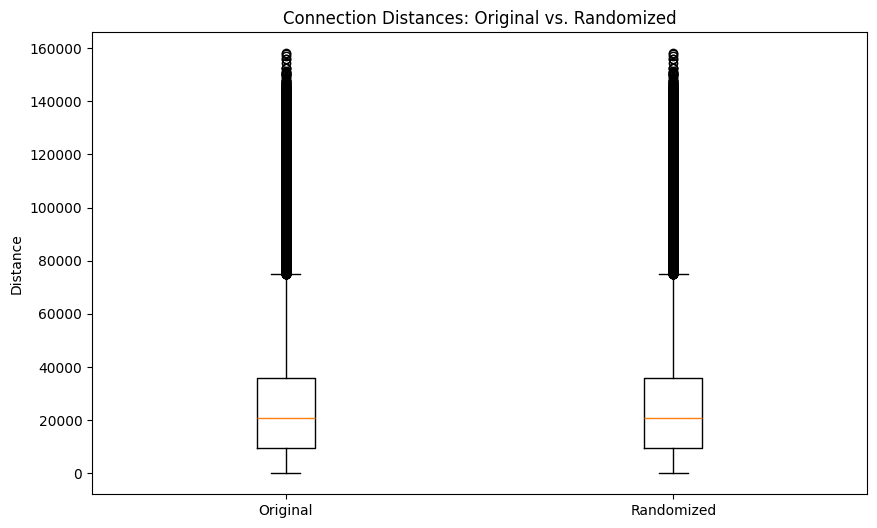

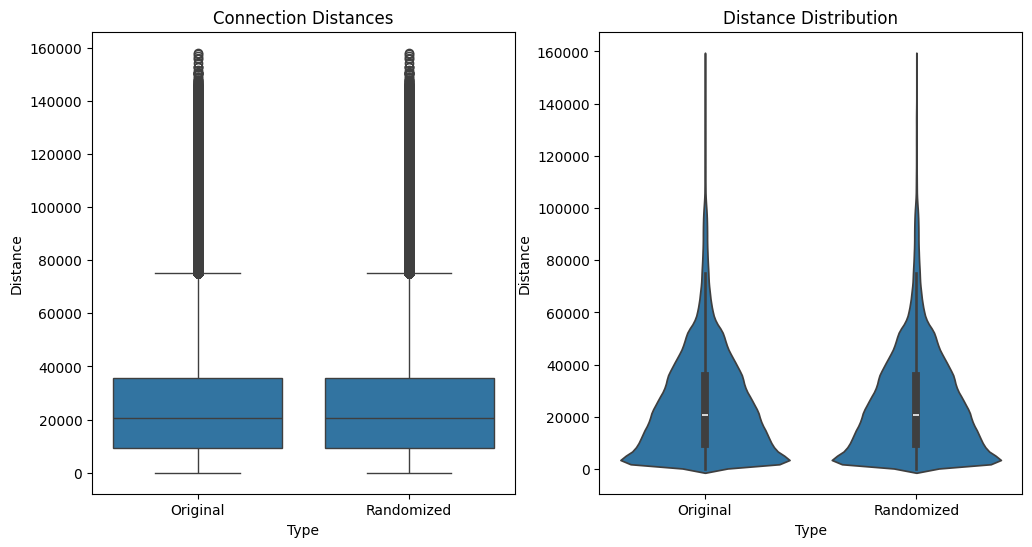

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from paths import PROJECT_ROOT

data_dir = os.path.join(PROJECT_ROOT, "new_data")
# Load data
connections = pd.read_csv(os.path.join(data_dir, "connections.csv"))
connections_random = pd.read_csv(os.path.join(data_dir, "connections_random_binned.csv"))
neurons = pd.read_csv(os.path.join(data_dir, "neuron_annotations.tsv"), sep="\t")

# Basic stats
print(
    f"Original connections: {len(connections)}, Random connections: {len(connections_random)}"
)
print(
    f"Original synapses: {connections['syn_count'].sum()}, Random synapses: {connections_random['syn_count'].sum()}"
)

# Prepare neuron coordinates
neuron_coords = neurons.copy()
neuron_coords["soma_x"].fillna(neuron_coords["pos_x"], inplace=True)
neuron_coords["soma_y"].fillna(neuron_coords["pos_y"], inplace=True)
neuron_coords["soma_z"].fillna(neuron_coords["pos_z"], inplace=True)
neuron_coords = neuron_coords[["root_id", "soma_x", "soma_y", "soma_z"]].set_index(
    "root_id"
)


# Function to add coordinates to connections
def add_coords(connections_df, coords_df):
    # Add pre-neuron coordinates
    df = connections_df.merge(
        coords_df,
        left_on="pre_root_id",
        right_index=True,
        how="left",
        suffixes=("", "_pre"),
    )

    # Add post-neuron coordinates
    df = df.merge(
        coords_df,
        left_on="post_root_id",
        right_index=True,
        how="left",
        suffixes=("", "_post"),
    )

    # Rename columns for clarity
    df = df.rename(
        columns={
            "soma_x": "pre_x",
            "soma_y": "pre_y",
            "soma_z": "pre_z",
            "soma_x_post": "post_x",
            "soma_y_post": "post_y",
            "soma_z_post": "post_z",
        }
    )

    return df

# Add coordinates to both samples
orig_with_coords = add_coords(connections, neuron_coords)
random_with_coords = add_coords(connections_random, neuron_coords)


# Calculate distances in a vectorized way
def calculate_distances(df):
    # Get coordinate arrays
    pre_coords = df[["pre_x", "pre_y", "pre_z"]].to_numpy()
    post_coords = df[["post_x", "post_y", "post_z"]].to_numpy()

    # Calculate distances
    distances = np.linalg.norm(pre_coords - post_coords, axis=1)

    # Calculate wiring length (distance * synapse count)
    wiring_length = distances * df["syn_count"].to_numpy()

    return distances, wiring_length


# Calculate distances for both datasets
orig_distances, orig_wiring = calculate_distances(
    orig_with_coords.dropna(subset=["pre_x", "post_x"])
)
random_distances, random_wiring = calculate_distances(
    random_with_coords.dropna(subset=["pre_x", "post_x"])
)

# Print summary statistics
print(
    f"\nDistance statistics (sample size: {len(orig_distances)} original, {len(random_distances)} random):"
)
print(
    f"Original mean distance: {np.mean(orig_distances):.2f}, median: {np.median(orig_distances):.2f}"
)
print(
    f"Random mean distance: {np.mean(random_distances):.2f}, median: {np.median(random_distances):.2f}"
)
print(f"Original total wiring: {np.sum(orig_wiring):.2f}")
print(f"Random total wiring: {np.sum(random_wiring):.2f}")
print(
    f"Wiring ratio (random/original): {np.sum(random_wiring)/np.sum(orig_wiring):.4f}"
)

# Create a boxplot comparing the distributions
plt.figure(figsize=(10, 6))
data = [orig_distances, random_distances]
labels = ["Original", "Randomized"]

plt.boxplot(data, labels=labels)
plt.ylabel("Distance")
plt.title("Connection Distances: Original vs. Randomized")
plt.savefig("distance_boxplot.png")

# Create a more detailed plot with seaborn
plt.figure(figsize=(12, 6))
df_combined = pd.DataFrame(
    {
        "Distance": np.concatenate([orig_distances, random_distances]),
        "Type": ["Original"] * len(orig_distances)
        + ["Randomized"] * len(random_distances),
    }
)

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x="Type", y="Distance", data=df_combined)
plt.title("Connection Distances")

# Violin plot (shows distribution better)
plt.subplot(1, 2, 2)
sns.violinplot(x="Type", y="Distance", data=df_combined)
plt.title("Distance Distribution")